# Global Population 

- Total population: SP.POP.TOTL
- Birth rate: SP.DYN.CBRT.IN
- Death rate: SP.DYN.CDRT.IN

In [1]:
import json
import requests
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.graph_objs as go

%matplotlib inline

In [2]:
def api_query(indicator_code, params):
    link = 'https://api.worldbank.org/v2/countries/all/indicators/'
    indicator = link + indicator_code
    r= requests.get(indicator, params=params)
    return r.json()

In [3]:
params= {'format': 'json', 'per_page': '1000', 'date':'1990:2017'}

In [4]:
population = api_query('SP.POP.TOTL', params)

In [36]:
# This is the header of json file
population[0]

{'page': 1,
 'pages': 8,
 'per_page': 1000,
 'total': 7392,
 'sourceid': '39',
 'lastupdated': '2019-10-02'}

In [37]:
# This is the first line in a json file
population[1][1]

{'indicator': {'id': 'SP.POP.TOTL', 'value': 'Population, total'},
 'country': {'id': '1A', 'value': 'Arab World'},
 'countryiso3code': 'ARB',
 'date': '2016',
 'value': 404024433,
 'unit': '',
 'obs_status': '',
 'decimal': 0}

In [38]:
len(population[1])

1000

In [40]:
population[0]['pages']

8

In [5]:
def full_query(indicator_code, params):
    pages = api_query(indicator_code, params)[0]['pages']
    data = pd.DataFrame()
    
    folder_name = '/Users/wafic/Documents/population_app/Data' 
    
    for page in range(pages):
        file_name = indicator_code+'_'+str(page)+'.txt'
        file_path = os.path.join(folder_name, file_name)
        params['page'] = page+1
        
        
        data_chunks = api_query(indicator_code, params)
        with open(file_path, 'w') as file:
            json.dump(data_chunks, file)

In [6]:
params= {'format': 'json', 'per_page': '1000', 'date':'1960:2017'}
full_query('SP.POP.TOTL', params)

In [11]:
def extract_data(folder_name):
    df_list = []

    for file in os.listdir(folder_name):
        
        if file.endswith('.txt'):
            
            try: 
                file_name = os.path.join(folder_name, file)

                with open(file_name) as json_file:
                    data = json.load(json_file)
                    for entry in data[1]:
                        df_list.append({
                            'country': entry['country']['value'],
                            'code': entry['country']['id'],
                            'year': entry['date'],
                            'value': entry['value']
#                             'indic':entry['indicator']['id']
                        })
            except:
                continue
                

    df = pd.DataFrame(df_list, columns=['country', 'code', 'year', 'value'])
    return df

In [12]:
population_full = extract_data('Data/')

In [13]:
len(population_full)

15312

In [14]:
population_full.head()

,country,code,year,value
0,Bermuda,BM,1961,45500.0
1,Bermuda,BM,1960,44400.0
2,Bhutan,BT,2017,745568.0
3,Bhutan,BT,2016,736709.0
4,Bhutan,BT,2015,727876.0


In [15]:
population_full.isnull().sum()

country      0
code         0
year         0
value      165
dtype: int64

In [17]:
population_full.dropna(inplace=True)

In [18]:
len(population_full)

15147

## Doing some data investigation

In [58]:
population_full.head()

,country,code,year,value
0,Bermuda,BM,1961,45500.0
1,Bermuda,BM,1960,44400.0
2,Bhutan,BT,2017,745568.0
3,Bhutan,BT,2016,736709.0
4,Bhutan,BT,2015,727876.0


In [60]:
population_full.groupby('country').value.sum().sort_values(ascending=False).reset_index()[:20]

,country,value
0,World,3.003729e+11
1,IDA & IBRD total,2.445176e+11
2,Low & middle income,2.428115e+11
3,Middle income,2.220873e+11
4,IBRD only,1.939851e+11
5,Early-demographic dividend,1.161587e+11
6,Upper middle income,1.142963e+11
7,Lower middle income,1.077910e+11
8,Late-demographic dividend,1.019267e+11
9,East Asia & Pacific,1.008768e+11


It is clear that country does not imply only country names but some world bank classifications

In [62]:
population_full.country.unique()

array(['Bermuda', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina',
       'Botswana', 'Brazil', 'British Virgin Islands',
       'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi',
       'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada', 'Cayman Islands',
       'Central African Republic', 'Chad', 'Channel Islands', 'Chile',
       'China', 'Colombia', 'Comoros', 'Congo, Dem. Rep.', 'Congo, Rep.',
       'Costa Rica', "Cote d'Ivoire", 'Croatia', 'Cuba', 'Curacao',
       'Cyprus', 'Czech Republic', 'Denmark', 'Djibouti', 'Dominica',
       'Dominican Republic', 'Germany', 'Ghana', 'Gibraltar', 'Greece',
       'Greenland', 'Grenada', 'Guam', 'Guatemala', 'Guinea',
       'Guinea-Bissau', 'Guyana', 'Haiti', 'Honduras',
       'Hong Kong SAR, China', 'Hungary', 'Iceland', 'India', 'Indonesia',
       'Ecuador', 'Egypt, Arab Rep.', 'El Salvador', 'Equatorial Guinea',
       'Eritrea', 'Estonia', 'Eswatini', 'Ethiopia', 'Faroe Islands',
       'Fiji', 'Finland', 'France', 'French Polyn

Look like there are three types:
- Indicators or classifications like 'Upper middle income'
- Regions like 'Euro area'
- Countries

## Stats by Country

In [64]:
population_full[population_full.country == 'Lebanon'].code.unique()

array(['LB'], dtype=object)

In [74]:
# Importing country code to extract country data first
country_code = pd.read_csv('Data/country_map.txt', sep='\t', dtype={'3let':str, '2let':str})

In [79]:
len(population_full)

15147

In [82]:
# Using inner merge, we will only include countries
country_pop = population_full.merge(country_code, left_on='code', right_on='2let')

In [81]:
len(country_pop)

12227

In [84]:
# Manual reading will show that we have only countries in this dataframe
country_pop.country.unique()

array(['Bermuda', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina',
       'Botswana', 'Brazil', 'British Virgin Islands',
       'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi',
       'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada', 'Cayman Islands',
       'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia',
       'Comoros', 'Congo, Dem. Rep.', 'Congo, Rep.', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Cuba', 'Cyprus', 'Czech Republic',
       'Denmark', 'Djibouti', 'Dominica', 'Dominican Republic', 'Germany',
       'Ghana', 'Gibraltar', 'Greece', 'Greenland', 'Grenada', 'Guam',
       'Guatemala', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Haiti',
       'Honduras', 'Hong Kong SAR, China', 'Hungary', 'Iceland', 'India',
       'Indonesia', 'Ecuador', 'Egypt, Arab Rep.', 'El Salvador',
       'Equatorial Guinea', 'Eritrea', 'Estonia', 'Eswatini', 'Ethiopia',
       'Faroe Islands', 'Fiji', 'Finland', 'France', 'French Polynesia',
       'Gabon', 'Gambia, The',

In [86]:
decades = ['1960', '1970', '1980', '1990', '2000', '2010', '2017']

In [87]:
country_pop_decad = country_pop[country_pop.year.isin(decades)].groupby('year')['value'].sum().reset_index()

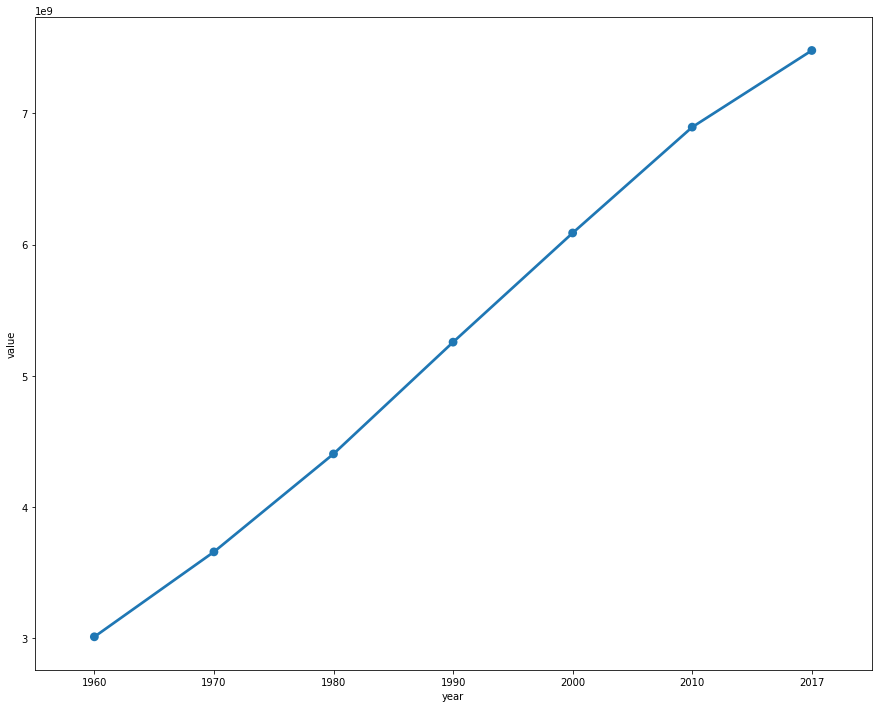

In [88]:
plt.figure(figsize=(15,12))
sns.pointplot(x='year', y='value', data= country_pop_decad)
plt.show()

In [101]:
pop_country= \
country_pop[country_pop.year.isin(['1960', '2017'])]\
.pivot(index = 'country', columns='year', values='value').reset_index()

In [102]:
pop_country['diff'] = pop_country['2017'] - pop_country['1960']

In [103]:
# Top 20 countries in term of difference between 1960 and 2017
top_20_growth = pop_country.sort_values('diff', ascending=False)[:20]

In [105]:
top_20_list = top_20_growth.country.unique()

In [113]:
final_top_20= country_pop[(country_pop.country.isin(top_20_list))&(country_pop.year.isin(decades))]

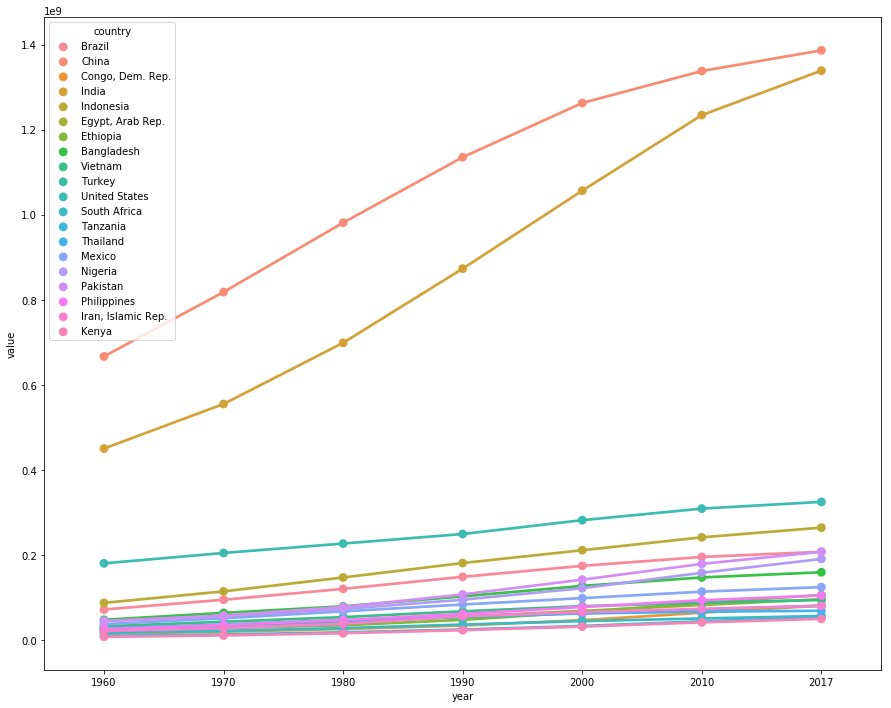

In [114]:
plt.figure(figsize=(15,12))
sns.pointplot(x='year', y='value', data= final_top_20, hue='country')
plt.show()

In [145]:
def countries_data(df):
    # This function extract the countries data from the World Bank API data
    country_code = pd.read_csv('Data/country_map.txt', sep='\t', dtype={'3let':str, '2let':str}) 
    country_pop = df.merge(country_code, left_on='code', right_on='2let')    
    return country_pop

## Taking Advantage of Other Classifications

In [117]:
population_full[~population_full.code.isin(country_code['2let'].unique())].country.unique()

array(['Channel Islands', 'Curacao', 'OECD members', 'Other small states',
       'Pacific island small states', 'Post-demographic dividend',
       'Pre-demographic dividend', 'Small states', 'South Asia',
       'South Asia (IDA & IBRD)', 'Sub-Saharan Africa',
       'Sub-Saharan Africa (excluding high income)',
       'Sub-Saharan Africa (IDA & IBRD countries)', 'Upper middle income',
       'World', 'IDA blend', 'IDA only', 'IDA total',
       'Late-demographic dividend', 'Latin America & Caribbean',
       'Latin America & Caribbean (excluding high income)',
       'Latin America & the Caribbean (IDA & IBRD countries)',
       'Least developed countries: UN classification',
       'Low & middle income', 'Low income', 'Lower middle income',
       'Middle East & North Africa',
       'Middle East & North Africa (excluding high income)',
       'Middle East & North Africa (IDA & IBRD countries)',
       'Middle income', 'North America', 'Arab World',
       'Caribbean small states',

In [131]:
wb_class = population_full[(population_full.country.str.contains('income'))&\
                ~(population_full.country.str.contains('excluding'))].country.unique().tolist()

In [132]:
wb_class

['Upper middle income',
 'Low & middle income',
 'Low income',
 'Lower middle income',
 'Middle income',
 'High income']

In [135]:
# Average popluation over the years
population_full[population_full.country.isin(wb_class)].groupby('country').value.mean()

country
High income            9.924380e+08
Low & middle income    4.186406e+09
Low income             3.573150e+08
Lower middle income    1.858465e+09
Middle income          3.829091e+09
Upper middle income    1.970626e+09
Name: value, dtype: float64

In [141]:
population_full_class = population_full[(population_full.country.isin(wb_class))&(population_full.year.isin(decades))]

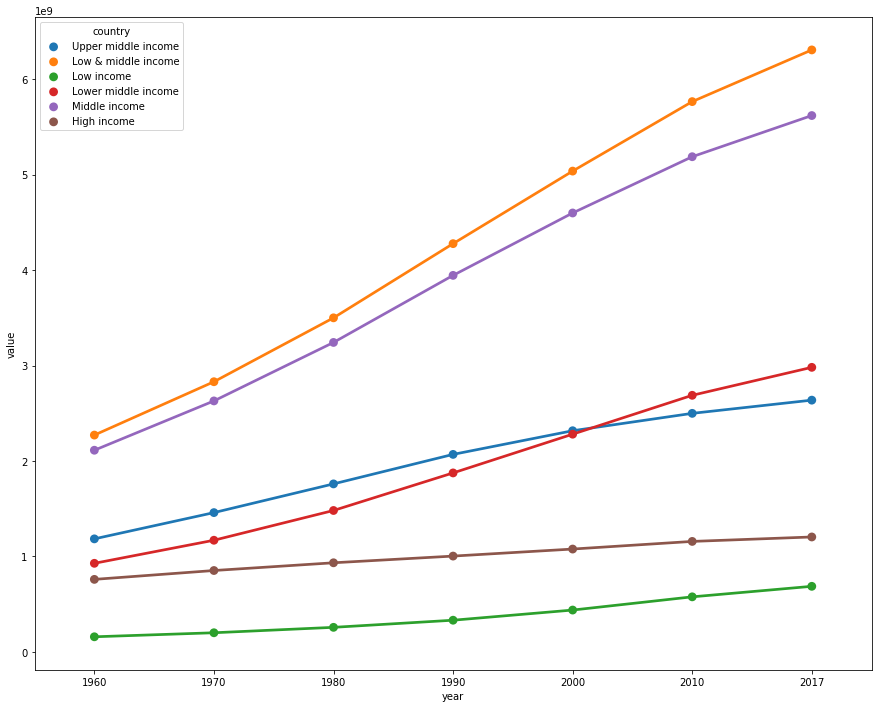

In [143]:
plt.figure(figsize=(15,12))
sns.pointplot(x='year', y='value', data= population_full_class, hue='country')
plt.show()

In [148]:
def income_classification(df):
    # This takes advantage of the calssifications available in the extracted data
    income_df = df[(df.country.isin(wb_class))&(df.year.isin(decades))] 
    return income_df

# Plotly Plotting

In [150]:
df_country = countries_data(population_full)

In [152]:
df_country_17 = df_country[df_country.year == '2017']

In [154]:
df_country_17.value.isnull().sum()

0

In [155]:
df_country_17.columns

Index(['country', 'code', 'year', 'value', 'Countrylet', '2let', '3let'], dtype='object')

In [161]:
graph_one = [dict(type = 'choropleth',
                 locations = df_country_17['3let'],
                 z= df_country_17['value'],
                 text = df_country_17['country'],
                 colorscale = 'Viridis',
                 autocolorscale = False,
                 reversescale = True,
                 marker = dict(
                     line = dict(
                         color = 'rgb(180, 180, 180)',
                         width = 0.5)),
                  colorbar = dict(title = 'Population (Billions)'),
                 )]

layout_one = dict(margin = dict(
    l = 30,
    r = 10,
    b = 0,
    t = 10,
    pad = 4
),
    geo =dict(
    landcolor = 'lightgray',
    showland = True,
    showcountries = True,
    countrycolor = 'gray',
    countrywidth = 0.5,
    showframe = False,
    showcoastlines = False,
    projection = dict(
        type='mercator'
    )
    )
                 )

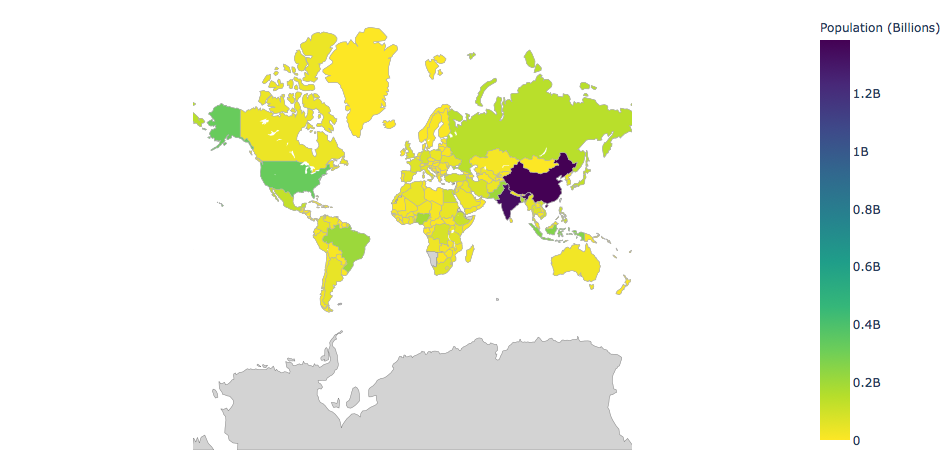

In [162]:
fig = go.Figure(data = graph_one, layout=layout_one)
fig.show()

In [186]:
df_classif = population_full[(population_full.country.isin(wb_class))&(population_full.year.isin(decades))]

In [187]:
df_classif.country.value_counts()

Middle income          7
High income            7
Lower middle income    7
Low & middle income    7
Upper middle income    7
Low income             7
Name: country, dtype: int64

In [188]:
df_classif = df_classif[df_classif.country.isin(['High income', 'Low income'])]

In [189]:
df_classif.drop(columns='code', inplace=True)

In [195]:
df_classif.head()

,country,year,value
6508,Low income,2017,687449530.0
6515,Low income,2010,577274011.0
6525,Low income,2000,438799433.0
6535,Low income,1990,332330635.0
6545,Low income,1980,257758125.0


In [203]:
high_low = df_classif.country.unique().tolist()


graph_two = []

for country in high_low:
        x_val = df_classif[df_classif['country'] == country].year.tolist()
        y_val = df_classif[df_classif['country'] == country].value.tolist()
        graph_two.append(
            go.Scatter(x=x_val, 
                       y=y_val, 
                       mode='lines+markers', 
                       marker = dict(
                           size=2.25,
                       ),
                       name=country)
        )
    
layout_two = dict(
        title = 'Difference in Population Growth between Highest and Lowest',
        xaxis = dict(
            title = 'Year',
            dtick = 5
        ),
        yaxis = dict(
            title = 'Population'
        ),
        hovermode = 'closest',
    )

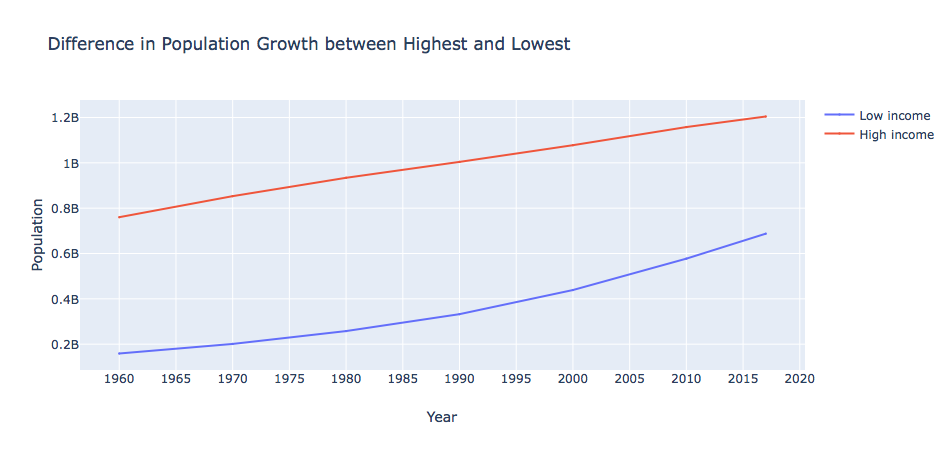

In [204]:
fig = go.Figure(data = graph_two, layout=layout_two)
fig.show()